In [1]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import numpy as np
import scipy.stats as sst
import scipy.signal as snl
from statsmodels.formula.api import ols, quantreg
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image, display

from nems_lbhb.baphy_io import  get_mean_spike_waveform

from src.data.load import load
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts
from src.data.cell_type import get_phototags, get_waveform_metrics
from src.root_path import config_path, root_path


config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


##### This notebook contains PAPER FIGURES!!!
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-09-22 165534.log


In [2]:
# quick and dirty, get the celltype dataframe, merge to main DF and run categorical linear regressions
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
type_DF = jl.load(type_DF_file)
type_DF = type_DF.loc[:, ['id', 'spike_type', 'phototag']]
type_DF.dropna(subset=['spike_type', 'phototag'], how='all')
type_DF.head()

,id,spike_type,phototag
0,TNC015a-25-3,broad,s
1,TNC016a-31-1,broad,s
2,ley075b-17-1,narrow,NaN
3,TNC023a-036-1,broad,s
4,TNC045a-021-1,narrow,a


In [3]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(91812, 8)


,id,context_pair,probe,value,metric,site,region,trans_pair
0,TNC023a-020-1,00_01,1,298.479523,integral,TNC023a,PEG,same_silence
1,TNC023a-021-1,00_01,1,173.879120,integral,TNC023a,PEG,same_silence
2,TNC023a-022-1,00_01,1,332.076965,integral,TNC023a,PEG,same_silence
3,TNC023a-022-2,00_01,1,244.306595,integral,TNC023a,PEG,same_silence
4,TNC023a-023-1,00_01,1,575.753906,integral,TNC023a,PEG,same_silence


In [4]:
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress, type_DF, on='id', validate="m:1")

# the simplest approach is to manually map the 4 categories into onehots
# onehot order: diff same silence
mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}
toregress['onehot'] = toregress['trans_pair'].replace(mapper)

onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
toregress = pd.concat([toregress, onehotdf], axis=1)

toregress.drop(columns='onehot', inplace=True)
del(onehotdf)
print(toregress.shape)
toregress.head()

(89824, 15)


,id,context_pair,probe,value,metric,site,region,trans_pair,grand_mean,norm_val,spike_type,phototag,diff,same,silence
0,TNC023a-020-1,00_01,1,298.479523,integral,TNC023a,PEG,same_silence,236.451141,1.262331,broad,n,0,1,1
1,TNC023a-020-1,00_03,1,304.968201,integral,TNC023a,PEG,diff_silence,236.451141,1.289773,broad,n,1,0,1
2,TNC023a-020-1,00_04,1,363.366364,integral,TNC023a,PEG,diff_silence,236.451141,1.536750,broad,n,1,0,1
3,TNC023a-020-1,00_05,1,194.660553,integral,TNC023a,PEG,diff_silence,236.451141,0.823259,broad,n,1,0,1
4,TNC023a-020-1,00_06,1,467.185333,integral,TNC023a,PEG,diff_silence,236.451141,1.975822,broad,n,1,0,1


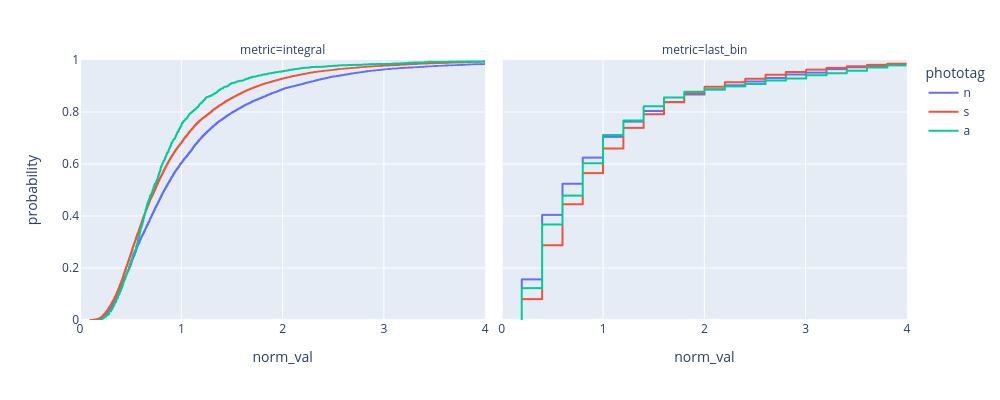

In [5]:
toplot = toregress.dropna(subset='phototag')

fig = px.ecdf(toplot, x="norm_val",  color='phototag', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [6]:
d = toregress.query("metric == 'integral'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     209.6
Date:                Thu, 22 Sep 2022   Prob (F-statistic):           2.60e-91
Time:                        16:55:45   Log-Likelihood:                -49585.
No. Observations:               41179   AIC:                         9.918e+04
Df Residuals:                   41176   BIC:                         9.920e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8628      0.022  

In [7]:
d = toregress.query("metric == 'last_bin'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     30.03
Date:                Thu, 22 Sep 2022   Prob (F-statistic):           9.28e-14
Time:                        16:55:46   Log-Likelihood:                -51559.
No. Observations:               41179   AIC:                         1.031e+05
Df Residuals:                   41176   BIC:                         1.031e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0127      0.023  

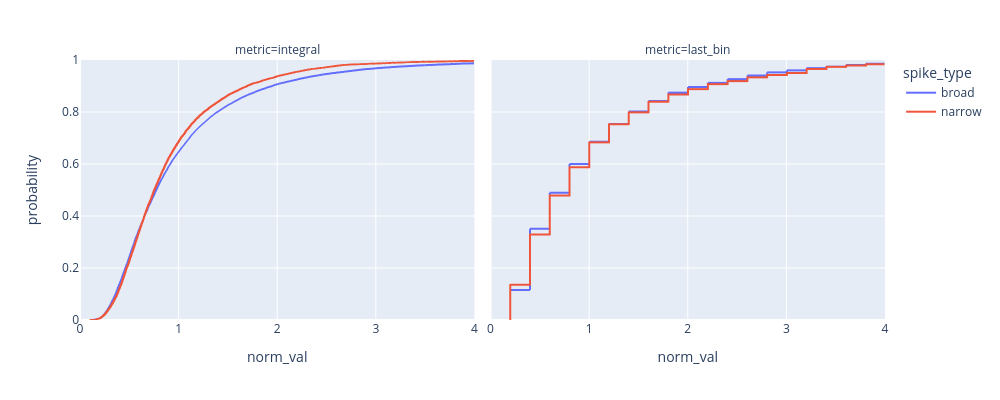

In [8]:
toplot = toregress.dropna(subset='spike_type')

fig = px.ecdf(toplot, x="norm_val",  color='spike_type', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [9]:
d = toregress.query("metric == 'last_bin'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.003
Date:                Thu, 22 Sep 2022   Prob (F-statistic):             0.0454
Time:                        16:55:51   Log-Likelihood:                -54975.
No. Observations:               44141   AIC:                         1.100e+05
Df Residuals:                   44139   BIC:                         1.100e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [10]:
d = toregress.query("metric == 'integral'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     103.8
Date:                Thu, 22 Sep 2022   Prob (F-statistic):           2.34e-24
Time:                        16:55:51   Log-Likelihood:                -53109.
No. Observations:               44141   AIC:                         1.062e+05
Df Residuals:                   44139   BIC:                         1.062e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# focus on spike width
The photo tagged units are restricted to narrow waveforms, whereas they are spread across all other categories.
Let just define categories based on spike waveforms

In [89]:
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
toclust = jl.load(type_DF_file).dropna(subset='sw')
print(toclust.shape)
toclust['siteid'] = toclust['id'].str.split('-').str[0]

# refresh phototags
pt = get_phototags()
pt.rename(columns={'cellid': 'id'}, inplace=True)
toclust.drop(columns=['phototag'], inplace=True)
toclust = pd.merge(toclust, pt, on=['siteid','id'], validate="1:1", how='left')

# uniffied phototagg, merge suppressed and neutral. names untagged
toclust['phototag2'] = toclust['phototag'].astype(object)
toclust.phototag2.replace({'n':'n+s', 's':'n+s'},inplace=True)
toclust.loc[toclust.phototag2.isnull(),'phototag2'] = 'untagged'
toclust['phototag2'] = toclust['phototag2'].astype('category')

# just activated
toclust['phototag3'] = toclust['phototag'].astype(object)
toclust.phototag3.replace({'a':True, 'n':False, 's':False},inplace=True)
toclust.loc[toclust.phototag3.isnull(),'phototag3'] = False
toclust['phototag3'] = toclust['phototag3'].astype(bool)

#classify which neurons were injected
toclust['injected'] = ~pd.isnull(toclust.phototag)

print(toclust.shape)
print(toclust.groupby(['phototag2']).agg(cell_count=('id', 'count')))
print(toclust.groupby(['phototag3']).agg(cell_count=('id', 'count')))

(1630, 12)
(1630, 15)
           cell_count
phototag2            
a                  51
n+s               885
untagged          694
           cell_count
phototag3            
False            1579
True               51


### find clusters
by simple historgram threshold. **this is working pretty well**

waveform threshold 0.42424242424242425


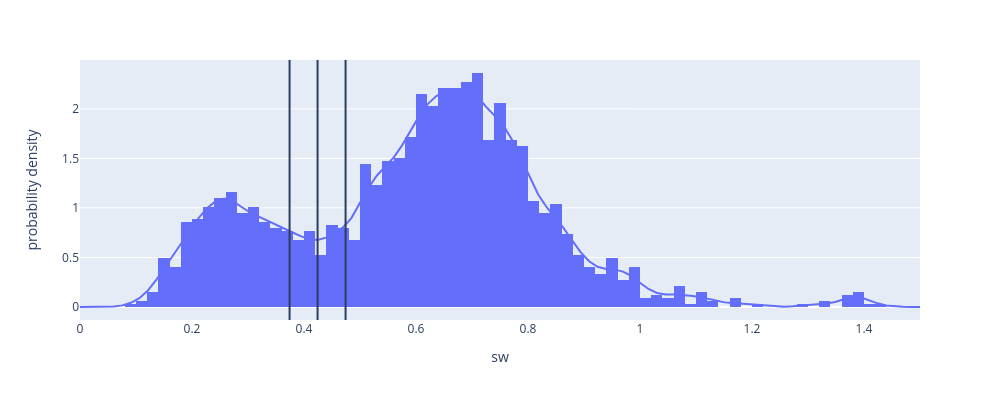

In [90]:
# define kernel density estimate, the bandwidth is defined empirically
kernel = sst.gaussian_kde(toclust.loc[~toclust.sw.isnull(), 'sw'], 0.1)
x = np.linspace(0, 1.5, 100)
hist = kernel(x)

# find valley in bimodal distribution
min_idx = snl.argrelmin(hist)[0]
# print(x[min_idx])
hist_threshold = x[min_idx[0]]
print(f'waveform threshold {hist_threshold}')
margin = 0.05 # plus or minus in ms

# Classifies base on valley plus an unclasified zone of 0.1ms
named_labels = np.empty(len(toclust['sw']), dtype=object)
named_labels[toclust['sw'] < (hist_threshold - margin)] = 'narrow'
named_labels[np.logical_and((hist_threshold - margin) <= toclust['sw'],
                            (toclust['sw'] < (hist_threshold + margin)))] = 'unclass'
named_labels[(hist_threshold + margin) <= toclust['sw']] = 'broad'

toclust['sw_kde'] = named_labels

# plot KDE on top of histogram
KDE_line = px.line(x=x, y=hist)
fig = px.histogram(toclust, x='sw', nbins=100, histnorm='probability density')
fig.add_traces(KDE_line['data'])
fig.add_vline(x=hist_threshold)
fig.add_vline(x=hist_threshold-margin)
fig.add_vline(x=hist_threshold+margin)
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

### double classification
This should not change much, the idea is that we merge putative narrow wave with photoactivated and we call it putative inhibitory interneurons.on the oter hand we take broad spikes that are not photo activated and we classify them as putative exitatory neurons.In other words the narrow wave cluster is gaining some exited neurons, and the wide cluster is loosing some.

In [91]:

putative = np.empty(toclust.shape[0], dtype=object)
inhibitory = np.logical_or(toclust.phototag3, toclust.sw_kde == 'narrow')

pyramidal = np.logical_and(~toclust.phototag3,
                           toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3,
                         toclust.sw_kde == 'unclass')

putative[inhibitory] = 'inhibitory'
putative[pyramidal] = 'pyramidal'
putative[unclass] = 'unclass'

toclust['putative'] = pd.Series(putative, dtype='category')


### Triple classification
Focus on narrow vs broad, pulling out the third clasiffication: activated, as a confirmation of narrow

In [92]:

triple = np.empty(toclust.shape[0], dtype=object)
activated = toclust.phototag == 'a'
narrow = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'narrow')
broad = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'unclass')

triple[toclust.phototag3] = 'activated'
triple[narrow] = 'narrow'
triple[broad] = 'broad'
triple[unclass] = 'unclass'

toclust['triple'] = pd.Series(triple, dtype='category')

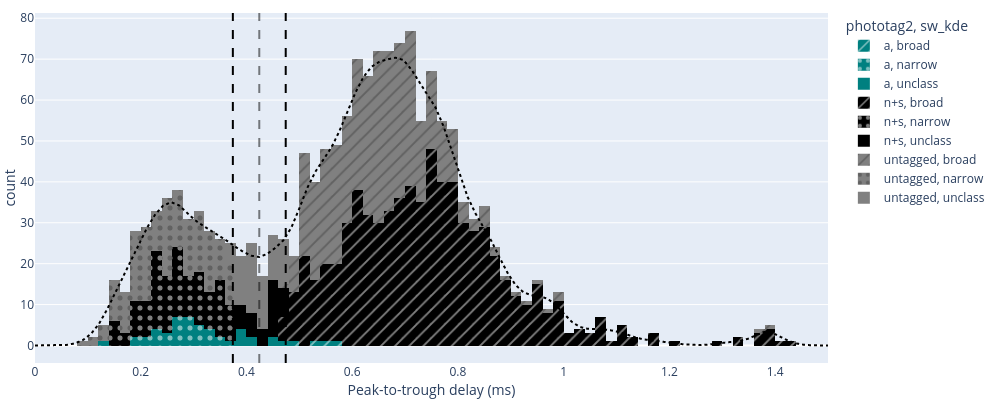

In [29]:
fig = px.histogram(toclust.dropna(subset=['phototag2']), nbins=100,
                   x='sw', color='phototag2',
                   pattern_shape='sw_kde',
                   pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
                   barmode='stack',
                   color_discrete_map={'a': "teal", 'n+s': "black", 'untagged':'gray'},
                   category_orders={'phototag2': ['a', 'n+s', 'untagged']},
                   )

# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toclust['sw'], 0.1)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 32
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='black', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash'),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash'))
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash'))

fig.update_layout(margin=dict(t=10,b=10,l=10,r=10),
                  yaxis=dict(title_standoff=0),
                  xaxis=dict(title=dict(standoff=0, text='Peak-to-trough delay (ms)')),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

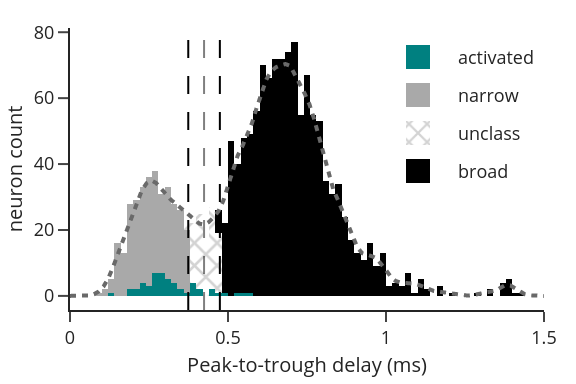

In [120]:
fig = px.histogram(toclust.dropna(subset=['triple']), nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': '', 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', "unclass": 'lightgray', "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )
fig.update_traces(marker_line_width=0)
# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toclust['sw'], 0.1)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 32
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='dimgray', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash',width=1),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash',width=1), opacity=1)
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash',width=1), opacity=1)


w, h= 3, 2
fig.update_layout(template='simple_white',
                  width=96*w, height=96*h,
                  margin=dict(t=10,b=10,l=10,r=10),
                  bargap=0,
                  xaxis=dict(title=dict(standoff=0,
                                        text='Peak-to-trough delay (ms)',
                                        font_size=10),
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='neuron count',
                                        standoff=0,
                                        font_size=10),
                             tickfont_size=9),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

filename = folder / 'fig5_cell_type_histogram'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96*w, height=96*h, scale=2)
Image(img_bytes)

## no injections sites
there is the fear that viral injections might damage the neurons and modify their behavior

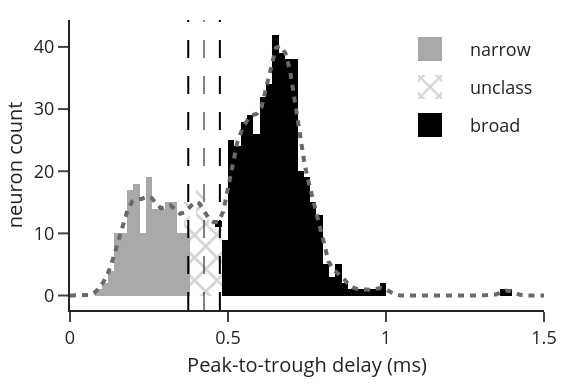

In [124]:
toplot = toclust.dropna(subset=['triple']).query('not injected')
fig = px.histogram(toplot,
                   nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': '', 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', "unclass": 'lightgray', "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )
fig.update_traces(marker_line_width=0)
# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toplot['sw'], 0.1)
del(toplot)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 14
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='dimgray', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash',width=1),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash',width=1), opacity=1)
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash',width=1), opacity=1)


w, h= 3, 2
fig.update_layout(template='simple_white',
                  width=96*w, height=96*h,
                  margin=dict(t=10,b=10,l=10,r=10),
                  bargap=0,
                  xaxis=dict(title=dict(standoff=0,
                                        text='Peak-to-trough delay (ms)',
                                        font_size=10),
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='neuron count',
                                        standoff=0,
                                        font_size=10),
                             tickfont_size=9),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

# filename = folder / 'fig5_cell_type_histogram_uninjected'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96*w, height=96*h, scale=2)
Image(img_bytes)

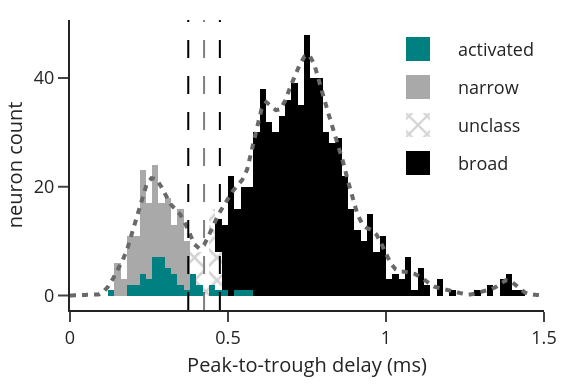

In [125]:
toplot = toclust.dropna(subset=['triple']).query('injected')
fig = px.histogram(toplot,
                   nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': '', 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', "unclass": 'lightgray', "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )
fig.update_traces(marker_line_width=0)
# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toplot['sw'], 0.1)
del(toplot)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 20
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='dimgray', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash',width=1),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash',width=1), opacity=1)
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash',width=1), opacity=1)


w, h= 3, 2
fig.update_layout(template='simple_white',
                  width=96*w, height=96*h,
                  margin=dict(t=10,b=10,l=10,r=10),
                  bargap=0,
                  xaxis=dict(title=dict(standoff=0,
                                        text='Peak-to-trough delay (ms)',
                                        font_size=10),
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='neuron count',
                                        standoff=0,
                                        font_size=10),
                             tickfont_size=9),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

# filename = folder / 'fig5_cell_type_histogram_injected'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96*w, height=96*h, scale=2)
Image(img_bytes)

### double classification
This should not change much, the idea is that we merge putative narrow wave with photoactivated and we call it
putative inhibitory interneurons. on the oter hand we take broad spikes that are not photo activated and we
classify them as putative exitatory neurons. In other words the narrow wave cluster is gaining some exited neurons,
and the wide cluster is loosing some.

In [32]:
putative = np.empty(toclust.shape[0], dtype=object)
inhibitory = np.logical_or(toclust.phototag3, toclust.sw_kde == 'narrow')

pyramidal = np.logical_and(~toclust.phototag3,
                           toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3,
                         toclust.sw_kde == 'unclass')


putative[inhibitory] = 'inhibitory'
putative[pyramidal] = 'pyramidal'
putative[unclass] = 'unclass'

toclust['putative'] = pd.Series(putative, dtype='category')

### Triple classification
Focus on narrow vs broad, pulling out the third clasiffication: activated, as a confirmation of narrrow

In [33]:
triple = np.empty(toclust.shape[0], dtype=object)
activated = toclust.phototag == 'a'
narrow = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'narrow')
broad = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'unclass')

triple[toclust.phototag3] = 'activated'
triple[narrow] = 'narrow'
triple[broad] = 'broad'
triple[unclass] = 'unclass'

toclust['triple'] = pd.Series(triple, dtype='category')

# effects by time chunks
lets focus on significant contextual modulation amplitude for chunks A and B, keeping instances that are significant
at any point in time,
furthermore, here we are plotting the delta firing rate independent of significance. however I am only keeping
instances that are significant on the whole duration of the probe.

In [111]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
# metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D']
metrics = ['integral', 'integral_nosig_A', 'integral_nosig_B', 'integral_nosig_C', 'integral_nosig_D']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' "
                                    )

# now filter the chunks based on the significance of the full probe
DF = pd.merge(DF.query("metric == 'integral' and value > 0").loc[:, ['id', 'context_pair', 'probe']],
              DF.query(f"metric in {[m for m in metrics if m != 'integral']}"),
              on=['id', 'context_pair', 'probe'], validate="1:m" )


DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

DF['chunk'] = DF.metric.str.split('_').str[-1]
DF['metric'] = DF.metric.str.split('_').str[0] + '_non_sig'

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress,
                     # toclust.loc[:,['id', 'phototag', 'phototag2', 'sw_kde', 'triple']],
                     toclust,
                     on='id', validate="m:1").reset_index(drop=True)
print(toregress.shape)
toregress.head()

(183624, 9)
(176564, 28)


,id,context_pair,probe,value,metric,site,region,trans_pair,chunk,grand_mean,...,isolation,spike_type,siteid,phototag,phototag2,phototag3,injected,sw_kde,putative,triple
0,ARM019a-19-7,00_01,1,79.672752,integral_non_sig,ARM019a,PEG,same_silence,A,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
1,ARM019a-19-7,00_01,1,192.542480,integral_non_sig,ARM019a,PEG,same_silence,B,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
2,ARM019a-19-7,00_01,1,53.115166,integral_non_sig,ARM019a,PEG,same_silence,C,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
3,ARM019a-19-7,00_01,1,86.312141,integral_non_sig,ARM019a,PEG,same_silence,D,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
4,ARM019a-19-7,01_04,1,53.115166,integral_non_sig,ARM019a,PEG,diff_same,A,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad


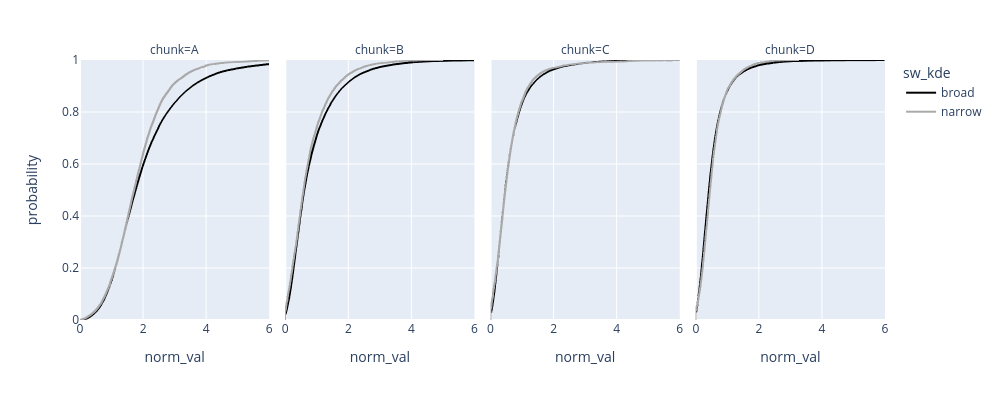

In [112]:
toplot = toregress.dropna(subset='sw_kde')
fig = px.ecdf(toplot.query("sw_kde != 'unclass'"),
              x="norm_val", color='sw_kde', facet_col='chunk',
              color_discrete_map={'narrow': 'darkgray',
                                  'broad': 'black'},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [37]:
for chunk in  toplot.chunk.unique():
    x = toplot.query(f"chunk == '{chunk}' and  sw_kde == 'narrow'").norm_val
    y = toplot.query(f"chunk == '{chunk}' and  sw_kde == 'broad'").norm_val
    stout = sst.ranksums(x, y)
    print(f'{chunk}, {stout}')

# print(toplot.groupby(['chunk','sw_kde']).agg(mean=('norm_val', 'mean')))

A, RanksumsResult(statistic=-8.958408301771708, pvalue=3.293987483708093e-19)
B, RanksumsResult(statistic=-8.3132241175761, pvalue=9.313638591963539e-17)
C, RanksumsResult(statistic=-1.7056992931027823, pvalue=0.08806408135511792)
D, RanksumsResult(statistic=5.747642652329184, pvalue=9.049624215191259e-09)


In [38]:
mod = ols("norm_val ~ C(sw_kde)*C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     8528.
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:56:20   Log-Likelihood:            -2.1207e+05
No. Observations:              176564   AIC:                         4.242e+05
Df Residuals:                  176552   BIC:                         4.243e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# phototag

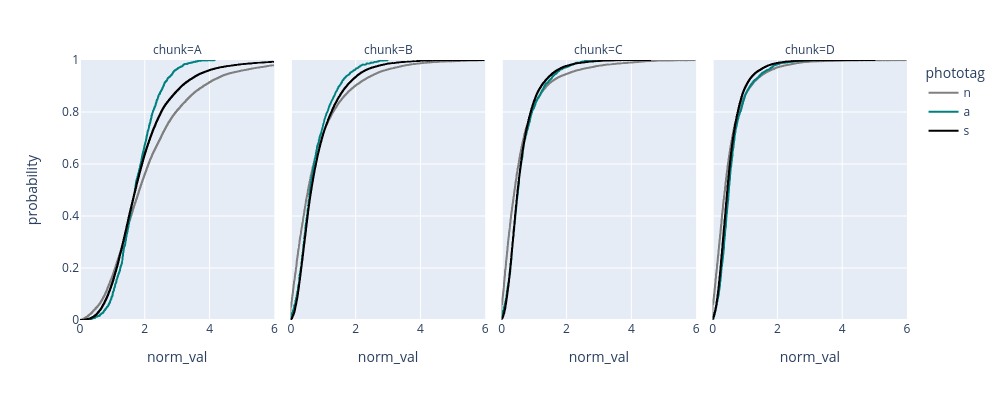

In [39]:
toplot = toregress.dropna(subset='phototag').query("phototag in ['a', 's', 'n']").copy()
toplot['phototag'] = toplot.phototag.cat.remove_unused_categories()
fig = px.ecdf(toplot, x="norm_val", color='phototag', facet_col='chunk',
              color_discrete_map={"a": "teal",
                                  "s": "black",
                                  "n": "gray"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [40]:
mod = ols("norm_val ~ C(phototag)*C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     7790.
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:56:32   Log-Likelihood:            -1.9487e+05
No. Observations:              161632   AIC:                         3.898e+05
Df Residuals:                  161620   BIC:                         3.899e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## simpliffied categorization
activated, narrow, and broad

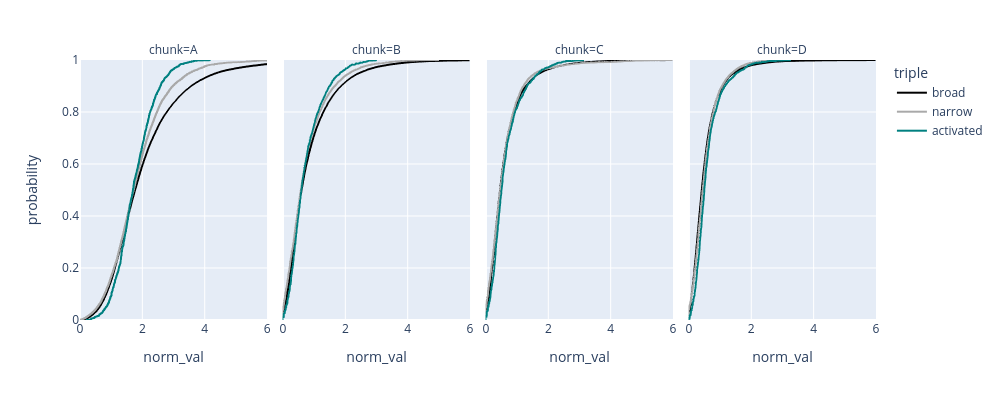

In [119]:
toplot = toregress.dropna(subset='triple').query("triple in ['activated', 'broad', 'narrow']").copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
fig = px.ecdf(toplot, x="norm_val", color='triple', facet_col='chunk',
              color_discrete_map={"activated": "teal",
                                  "broad": "black",
                                  "narrow": "darkgray"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

# back to full duration
since there is nothing particularly interesting for individual time chunks, rater focus on the full length

In [128]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
metrics = ['integral', 'last_bin', 'integral_nosig']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} "
                                    f"and cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' "
                                    f"and analysis == 'SC' "
                                    )

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis',], inplace=True)
DF['metric'] = DF.metric.cat.remove_unused_categories()
DF.reset_index(drop=True, inplace=True)

# use the integrale value to find instances that are significant, and a new significance column
signif_filter = DF.query("metric == 'integral' and value > 0").loc[:,['id', 'context_pair', 'probe']].copy()
signif_filter['significant'] = True

DF = pd.merge(DF, signif_filter, on=['id','context_pair','probe'], how='left', validate='m:1')
DF.loc[DF.significant.isnull(),'significant'] = False
DF['significant'] = DF.significant.astype(bool)


for col in ['id','context_pair','probe','site', 'region', 'metric', 'stim_count']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

DF = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
DF['norm_val'] = DF['value']/DF['grand_mean']
DF.drop(columns=['grand_mean'], inplace=True)

# add celltype labels
toregress = pd.merge(DF,
                     toclust,
                     on='id', validate="m:1").reset_index(drop=True)

print(toregress.shape)
toregress.head()

(1438200, 27)


,id,context_pair,probe,value,metric,site,region,stim_count,significant,norm_val,...,isolation,spike_type,siteid,phototag,phototag2,phototag3,injected,sw_kde,putative,triple
0,ARM019a-03-6,00_01,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
1,ARM019a-03-6,00_02,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
2,ARM019a-03-6,00_03,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
3,ARM019a-03-6,00_04,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
4,ARM019a-03-6,01_02,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad


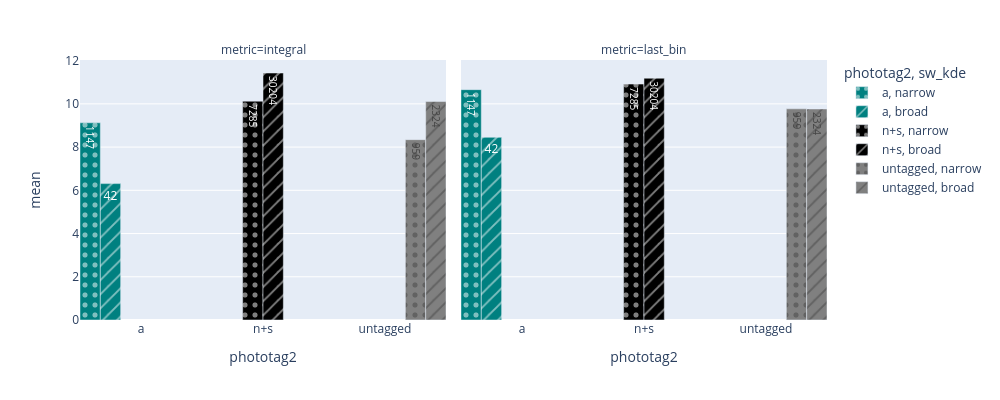

In [49]:
toplot = toregress.query("sw_kde in ['narrow', 'broad'] "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).groupby(['phototag2', 'sw_kde', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()
toplot.dropna(subset='mean', inplace=True)
fig = px.bar(toplot,
             x='phototag2', y='mean', pattern_shape='sw_kde', color='phototag2',
             barmode='group', text='count', facet_col='metric',
             pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
             color_discrete_map={'a': 'teal', 'n+s': 'black', 'untagged': 'gray'},
             category_orders={'sw_kde': ['narrow', 'broad'],
                              'phototag2': ['a', 'n+s', 'untagged']})

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

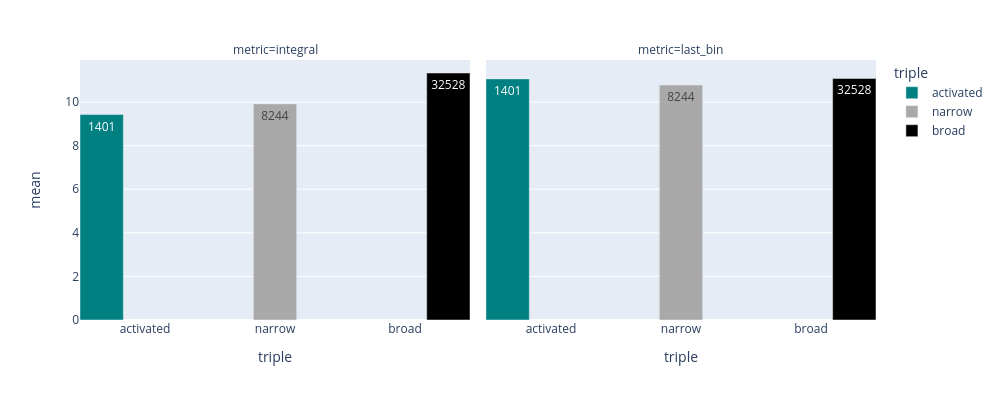

In [50]:
toplot = toregress.query("triple in ['activated', 'narrow', 'broad'] "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()
toplot = toplot.groupby(['triple', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()


fig = px.bar(toplot,
             x='triple', y='mean', color='triple',
             barmode='group', text='count', facet_col='metric',
             # pattern_shape='triple',
             # pattern_shape_map={'narrow': '.', 'activated': '.', 'broad': '/'},
             color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              })

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

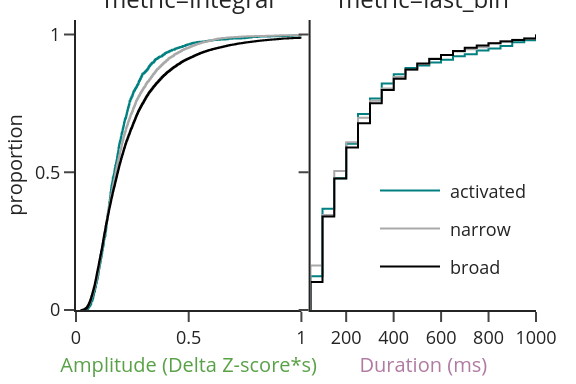

In [129]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()

# integral in seconds instead of ms
toplot.loc[toplot.metric == 'integral', 'value'] = toplot.loc[toplot.metric == 'integral', 'value'] / 1000

toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='value', color='triple', facet_col='metric',
              color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
_ = fig.update_traces(line_width=1)

# formating
w, h = 3, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None, autorange=False,
                             range=[0, 1],
                             title=dict(text='Amplitude (Delta Z-score*s)',
                                        font_color=AMPCOLOR)),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),
                  xaxis2=dict(matches=None, autorange=True,
                              title=dict(text='Duration (ms)',
                                         font_color=DURCOLOR)),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_context_effect_by_celltype'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

### statistical test of difference on fourth quartile

In [52]:
mod = quantreg("norm_val ~ C(triple)", toplot.query("metric == 'integral'"))
res = mod.fit(q=0.75)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               norm_val   Pseudo R-squared:             0.003549
Model:                       QuantReg   Bandwidth:                      0.7023
Method:                 Least Squares   Sparsity:                        28.98
Date:                Thu, 22 Sep 2022   No. Observations:                42173
Time:                        16:56:51   Df Residuals:                    42170
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.9530      0.336     32.622      0.000      10.295      11.611
C(triple)[T.broad]      2.7389      0.343      7.988      0.000       2.067       3.411
C(triple)[T.narrow]     1.2489      0.363      3.440      0.001       0.537       1.961


In [146]:
mod = ols("norm_val ~ C(triple)", toplot.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     106.3
Date:                Thu, 22 Sep 2022   Prob (F-statistic):           8.58e-47
Time:                        18:17:46   Log-Likelihood:            -1.5192e+05
No. Observations:               42173   AIC:                         3.039e+05
Df Residuals:                   42170   BIC:                         3.039e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.4249    

In [53]:
import itertools as itt
df = list()
for met in  toplot.metric.unique():
    for c0, c1 in itt.combinations(toplot.triple.unique(),r=2):
        x = toplot.query(f"metric == '{met}' and  triple == '{c0}'").norm_val
        y = toplot.query(f"metric == '{met}' and  triple == '{c1}'").norm_val
        stout = sst.ranksums(x, y)
        df.append(dict(metric=met, class0=c0, class1=c1,
                       mean0=np.median(x), mean1=np.median(y),
                       quant0=np.quantile(x, 0.75), quant1=np.quantile(y, 0.75),
                       pvalue=stout.pvalue))
        # print(f'{met} {c0} vs {c1}, {stout}')

df = pd.DataFrame(df)
df['significant'] = df['pvalue'] < 0.05/df.shape[0]
df

,metric,class0,class1,mean0,mean1,quant0,quant1,pvalue,significant
0,integral,broad,narrow,8.561819,8.136767,13.691913,12.202846,5.641937e-11,True
1,integral,broad,activated,8.561819,7.847061,13.691913,10.953016,3.955033e-07,True
2,integral,narrow,activated,8.136767,7.847061,12.202846,10.953016,3.606433e-02,False
3,last_bin,broad,narrow,8.764825,6.573618,13.147237,13.147237,1.242005e-07,True
4,last_bin,broad,activated,8.764825,8.764825,13.147237,13.147237,7.327331e-02,False
5,last_bin,narrow,activated,6.573618,8.764825,13.147237,13.147237,5.045290e-01,False


### injected vs not injected

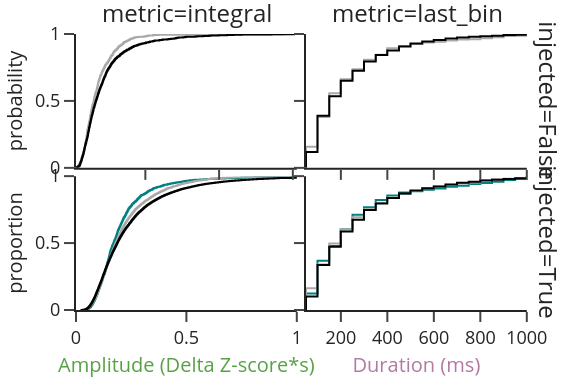

In [132]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()

# integral in seconds instead of ms
toplot.loc[toplot.metric == 'integral', 'value'] = toplot.loc[toplot.metric == 'integral', 'value'] / 1000

toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='value', color='triple', facet_col='metric', facet_row='injected',
              color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
del(toplot)
_ = fig.update_traces(line_width=1)

# formating
w, h = 3, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None, autorange=False,
                             range=[0, 1],
                             title=dict(text='Amplitude (Delta Z-score*s)',
                                        font_color=AMPCOLOR)),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),
                  xaxis2=dict(matches=None, autorange=True,
                              title=dict(text='Duration (ms)',
                                         font_color=DURCOLOR)),

                  )
# commong features of both x axes
fig.update_xaxes(matches=None, title=dict(font_size=10, standoff=0), tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0), tickfont_size=9,
                 range=[0,1])

# filename = folder / 'fig5_context_effect_by_celltype'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

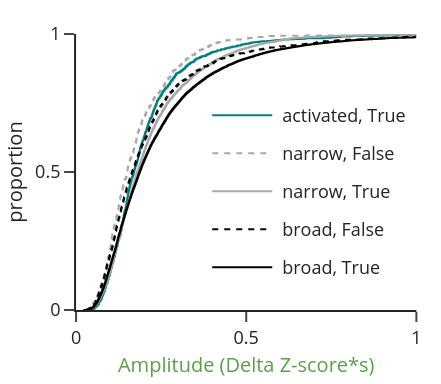

In [182]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric == 'integral'"
                         "and significant"
                         ).copy()

# integral in seconds instead of ms
toplot.loc[toplot.metric == 'integral', 'value'] = toplot.loc[toplot.metric == 'integral', 'value'] / 1000

toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='value', color='triple', line_dash='injected',
              line_dash_sequence={True:'solid', False:'dot'},
              color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
_ = fig.update_traces(line_width=1)

# formating
w, h = 2.3,2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  # showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(autorange=False,
                             range=[0, 1],
                             title=dict(text='Amplitude (Delta Z-score*s)',
                                        font_color=AMPCOLOR)),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),
                  # xaxis2=dict(matches=None, autorange=True,
                  #             title=dict(text='Duration (ms)',
                  #                        font_color=DURCOLOR)),

                  )
# commong features of both x axes
fig.update_xaxes(matches=None, title=dict(font_size=10, standoff=0), tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0), tickfont_size=9,
                 range=[0,1])

filename = folder / 'fig5_injection_effect'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

In [147]:
mod = quantreg("norm_val ~ C(injected)", toplot.query("metric == 'integral'"))
res = mod.fit(q=0.75)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               norm_val   Pseudo R-squared:             0.002031
Model:                       QuantReg   Bandwidth:                      0.6983
Method:                 Least Squares   Sparsity:                        30.81
Date:                Thu, 22 Sep 2022   No. Observations:                42173
Time:                        18:30:48   Df Residuals:                    42171
                                        Df Model:                            1
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.3769      0.233     48.863      0.000      10.921      11.833
C(injected)[T.True]     2.0611      0.242      8.501      0.000       1.586       2.536


In [148]:
mod = ols("norm_val ~ C(triple)", toplot.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     106.3
Date:                Thu, 22 Sep 2022   Prob (F-statistic):           8.58e-47
Time:                        18:30:50   Log-Likelihood:            -1.5192e+05
No. Observations:               42173   AIC:                         3.039e+05
Df Residuals:                   42170   BIC:                         3.039e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.4249    

## non singificant
same as above but considering integral regardless of significance.
what thise somehow bring into the plot the proportion of significance instances per group,
but obscures the group differences in  the actual significant contextual effects

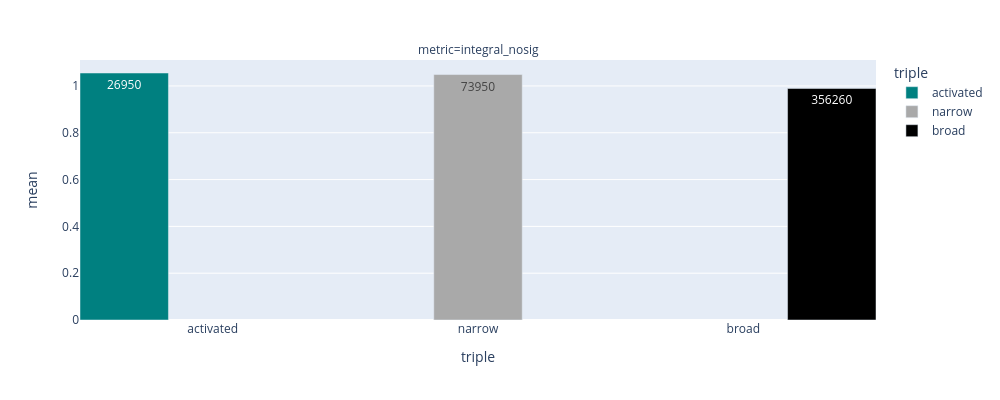

In [54]:
toplot = toregress.query("triple in ['activated', 'narrow', 'broad'] "
                         "and metric in ['integral_nosig']"
                         # "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()
toplot = toplot.groupby(['triple', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()


fig = px.bar(toplot,
             x='triple', y='mean', color='triple',
             barmode='group', text='count', facet_col='metric',
             # pattern_shape='triple',,
             # pattern_shape_map={'narrow': '.', 'activated': '.', 'broad': '/'},
             color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              })

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

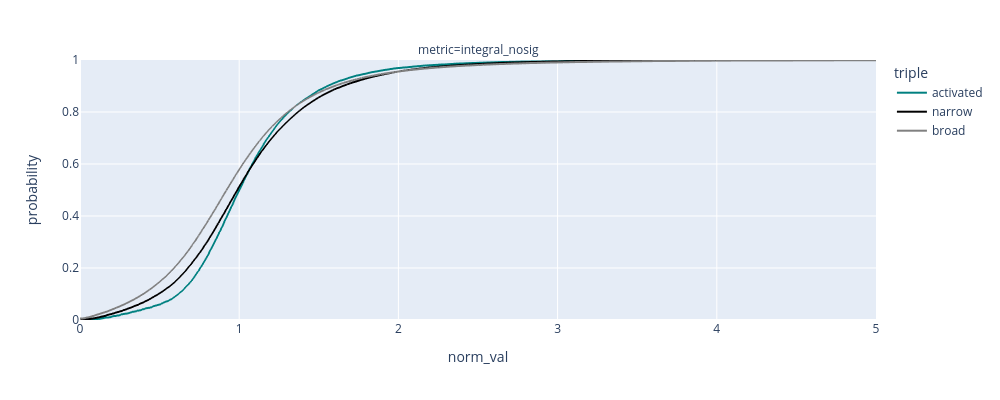

In [55]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral_nosig']"
                         # "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='norm_val', color='triple', facet_col='metric',
              color_discrete_map={'activated': 'teal', 'narrow': 'black', 'broad': 'gray'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               })

fig.update_layout(bargap=0.0, bargroupgap=0.0,
                  xaxis_range=[0, 5],
                  yaxis_range=[0, 1])

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [56]:
import itertools as itt
df = list()
for met in  toplot.metric.unique():
    for c0, c1 in itt.combinations(toplot.triple.unique(),r=2):
        x = toplot.query(f"metric == '{met}' and  triple == '{c0}'").value
        y = toplot.query(f"metric == '{met}' and  triple == '{c1}'").value
        stout = sst.ranksums(x, y)
        df.append(dict(metric=met, class0=c0, class1=c1,
                       mean0=np.mean(x), mean1=np.mean(y), pvalue=stout.pvalue))
        # print(f'{met} {c0} vs {c1}, {stout}')

df = pd.DataFrame(df)
df['significant'] = df['pvalue'] < 0.05/df.shape[0]
df

,metric,class0,class1,mean0,mean1,pvalue,significant
0,integral_nosig,broad,narrow,256.555939,271.972443,0.000000e+00,True
1,integral_nosig,broad,activated,256.555939,273.676758,1.338554e-270,True
2,integral_nosig,narrow,activated,271.972443,273.676758,4.553409e-11,True


# check proportion
what number of significant instances per category? is there a greater likelyhood of showing contextual
effects for inhibitory or pyramidal neurons?

  phototag2  sw_kde  sig_prcnt   count
0       n+s   broad   8.902119  339290
1       n+s  narrow  11.275344   64610
2         a   broad   1.909091    2200
3         a  narrow   5.636364   20350
4  untagged   broad   0.303030    1650
5  untagged  narrow   0.242424    3300


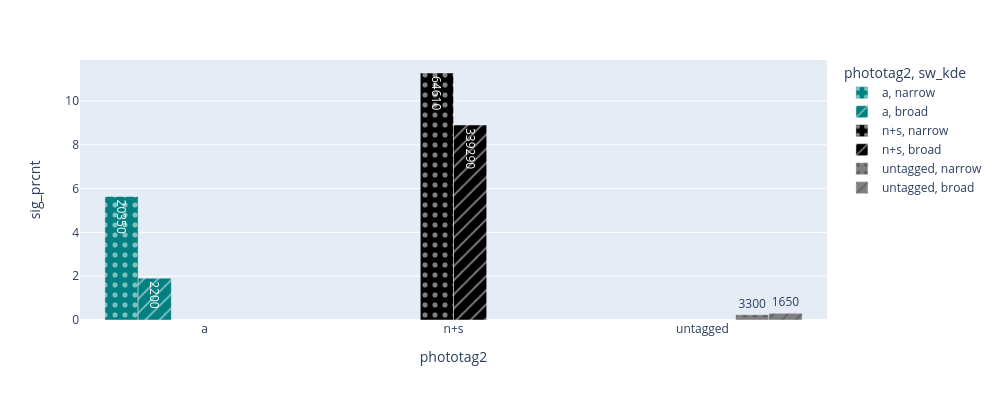

In [162]:
sig_prop = toregress.query(
    "sw_kde in ['narrow', 'broad'] "
    "and metric == 'integral' "
    "and stim_count in [9, 10]"
).groupby(
    ['phototag2', 'sw_kde'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

print(sig_prop)
fig = px.bar(sig_prop,
             x='phototag2', y='sig_prcnt', pattern_shape='sw_kde', color='phototag2',
             text='count',
             barmode='group',
             pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
             color_discrete_map={'a': 'teal', 'n+s': 'black', 'untagged': 'gray'},
             category_orders={'sw_kde': ['narrow', 'broad'],
                              'phototag2': ['a', 'n+s', 'untagged']})

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

      triple  sig_prcnt   count
0      broad   9.130410  356260
1     narrow  11.148073   73950
2  activated   5.198516   26950


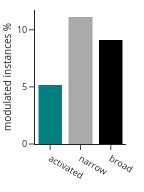

In [177]:
sig_prop = toregress.query(
    "triple in ['activated', 'narrow', 'broad'] "
    "and metric == 'integral' "
    # "and stim_count in [9, 10]"
).groupby(
    ['triple'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

print(sig_prop)
fig = px.bar(sig_prop,
             x='triple',
             y='sig_prcnt', color='triple',
             barmode='stack',
             # text='count',
             pattern_shape_map={'narrow': '.', 'activated': '', 'broad': '/'},
             color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad']}
             )

# formating
w, h = 1.5, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None,
                             title_text=None,
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='modulated instances %', font_size=10, standoff=0),
                             tickfont_size=9),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_percent_modulated_by_celltype'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=1)
Image(img_bytes)

In [171]:
toregress.triple.unique()

['broad', 'narrow', 'unclass', 'activated']
Categories (4, object): ['activated', 'broad', 'narrow', 'unclass']

      triple  injected  sig_prcnt   count
0      broad     False  13.694755   16970
1      broad      True   8.902119  339290
2     narrow     False  10.267666    9340
3     narrow      True  11.275344   64610
4  activated      True   5.198516   26950


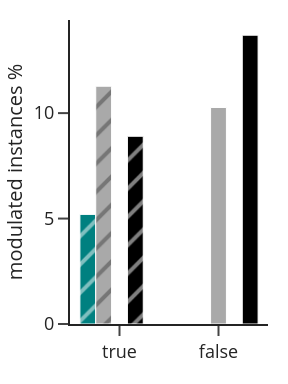

In [181]:
sig_prop = toregress.query(
    "triple in ['activated', 'narrow', 'broad'] "
    "and metric == 'integral' "
    # "and stim_count in [9, 10]"
).groupby(
    ['triple', 'injected'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

sig_prop['triple'] = sig_prop['triple'].cat.remove_unused_categories()
print(sig_prop)
fig = px.bar(sig_prop,
             x='injected', pattern_shape='injected',
             y='sig_prcnt', color='triple',
             barmode='group',
             # text='count',
             pattern_shape_map={True: '/', False: ''},
             color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              'injected': [True, False]}
             )

# formating
w, h = 1.5, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None,
                             title_text=None,
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='modulated instances %', font_size=10, standoff=0),
                             tickfont_size=9),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_percent_modulated_by_injection'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

# Firing rate
since firing rate has a small effect on contextthere is a slim chance that firing rate will ha

In [59]:
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220901_raw_fr_by_instance' # zscored firing rate
fr_DF = jl.load(fr_DF_file)

# simply takes the cell mean firing rate across all contexts, probes, and pupil sizes
fr_DF = fr_DF.query("chunk == 'full' and pupil == 'full' and part == 'probe' and metric == 'firing_rate'"
                  ).groupby(['id'], observed=True).agg(FR=('value', 'mean')).reset_index()

print(fr_DF.shape)
print(fr_DF.head())

(1669, 2)
             id        FR
0  AMT020a-02-1  1.771375
1  AMT020a-04-1  0.437125
2  AMT020a-07-1  0.008250
3  AMT020a-08-1  0.359875
4  AMT020a-13-1  0.196000


In [60]:
fr_cls_DF = pd.merge(fr_DF, toclust, on=['id'], validate="1:1")

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


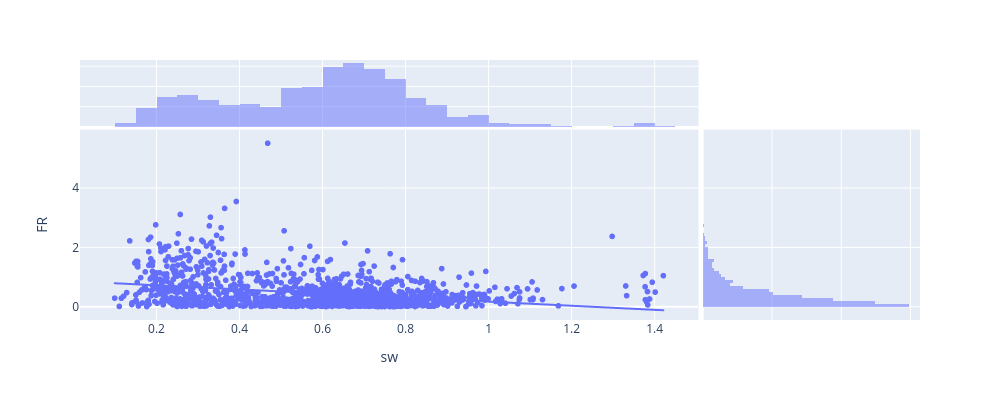

In [61]:
fig = px.scatter(fr_cls_DF, y='FR', x='sw', trendline='ols', marginal_x='histogram', marginal_y='histogram')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


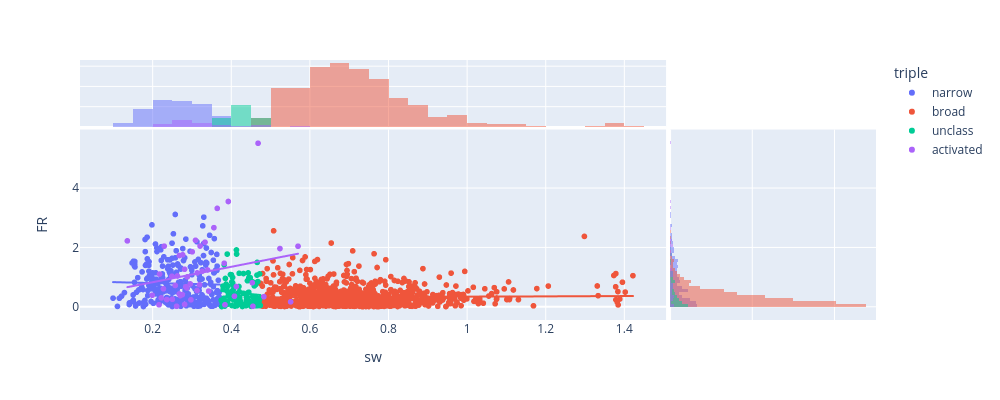

In [62]:
fig = px.scatter(fr_cls_DF, y='FR', x='sw',
                 color='triple',
                 trendline='ols', marginal_x='histogram', marginal_y='histogram')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


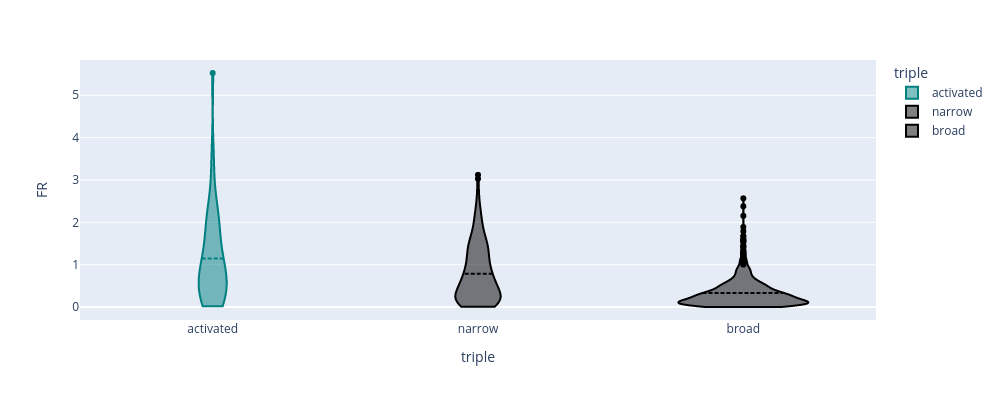

In [63]:
fig = px.violin(fr_cls_DF.query("triple != 'unclass'"),
                y='FR', x='triple', color='triple',
                color_discrete_map={'activated': 'teal', 'narrow': 'black', 'broad': 'black'},
                category_orders={'triple': ['activated', 'narrow', 'broad']},
                )
fig.update_traces(meanline_visible=True,
                  # marker_size=2,
                  # points='outliers',
                  # jitter=0.1,
                  # scalemode='width',
                  spanmode='hard')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

In [64]:
mod = ols("FR ~ C(triple)", data=fr_cls_DF.query("triple != 'unclass'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     FR   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     160.1
Date:                Thu, 22 Sep 2022   Prob (F-statistic):           6.27e-63
Time:                        16:57:26   Log-Likelihood:                -849.29
No. Observations:                1316   AIC:                             1705.
Df Residuals:                    1313   BIC:                             1720.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1474 

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning:

divide by zero encountered in double_scalars



## FR vs Percent Significant
this is not in

In [65]:
sig_prcnt_DF = DF.query(
    "metric == 'integral'"
).groupby(
    ['stim_count', 'id'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()
print(sig_prcnt_DF.shape)
print(sig_prcnt_DF.head())

(1722, 4)
  stim_count            id  sig_prcnt  count
0          4  ARM019a-03-6       10.0     40
1          4  ARM019a-06-5        5.0     40
2          4  ARM019a-07-6       50.0     40
3          4  ARM019a-10-5        7.5     40
4          4  ARM019a-10-6        0.0     40


In [66]:
fr_sig_DF = pd.merge(fr_DF, sig_prcnt_DF, on=['id'], validate="1:1")

LinregressResult(slope=7.302760528245109, intercept=8.230659208699274, rvalue=0.23826190295091113, pvalue=5.67402521944779e-23, stderr=0.7290775869784075, intercept_stderr=0.4899779507499946)


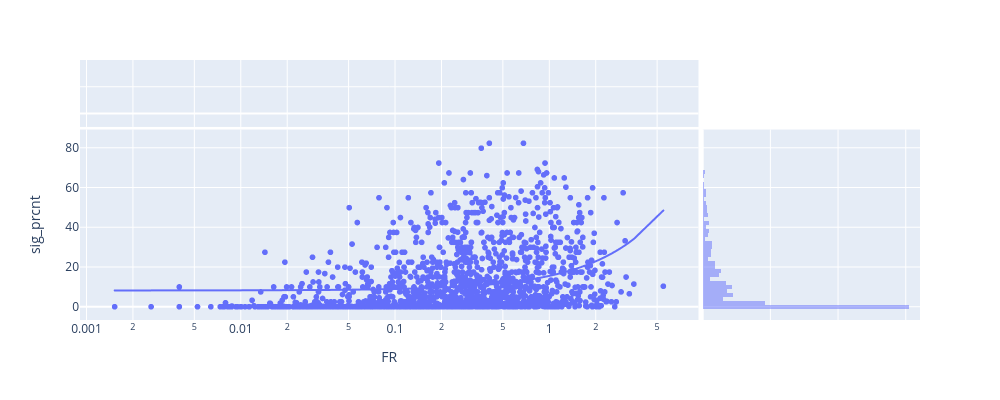

In [67]:
fig = px.scatter(fr_sig_DF, x='FR', y='sig_prcnt', trendline='ols',
                 log_x=True,
                 marginal_x='histogram', marginal_y='histogram')

print(sst.linregress(x=fr_sig_DF.FR,y=fr_sig_DF.sig_prcnt))
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [68]:
# define a set of bins for the long firing rate
fr_DF['logFR'] = np.log10(fr_DF['FR'])
q = 9
fr_DF['quant'] = pd.qcut(fr_DF['logFR'],q, labels=list(range(q)))

In [69]:
toplot = pd.merge(toregress.query("metric =='integral' and significant and triple != 'unclass'"),
                  fr_DF.reset_index(), on='id', validate='m:1')
toplot.head()

,id,context_pair,probe,value,metric,site,region,stim_count,significant,norm_val,sw,phototag2,phototag3,sw_kde,putative,triple,index,FR,logFR,quant
0,ARM019a-03-6,00_03,3,348.194641,integral,ARM019a,PEG,4,True,16.085339,0.600787,untagged,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
1,ARM019a-03-6,01_03,3,560.980286,integral,ARM019a,PEG,4,True,25.915268,0.600787,untagged,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
2,ARM019a-03-6,02_03,3,367.538818,integral,ARM019a,PEG,4,True,16.978970,0.600787,untagged,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
3,ARM019a-03-6,03_04,3,444.915405,integral,ARM019a,PEG,4,True,20.553490,0.600787,untagged,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
4,ARM019a-06-5,01_03,1,389.830322,integral,ARM019a,PEG,4,True,18.008757,0.212927,untagged,False,narrow,inhibitory,narrow,253,0.158125,-0.800999,3


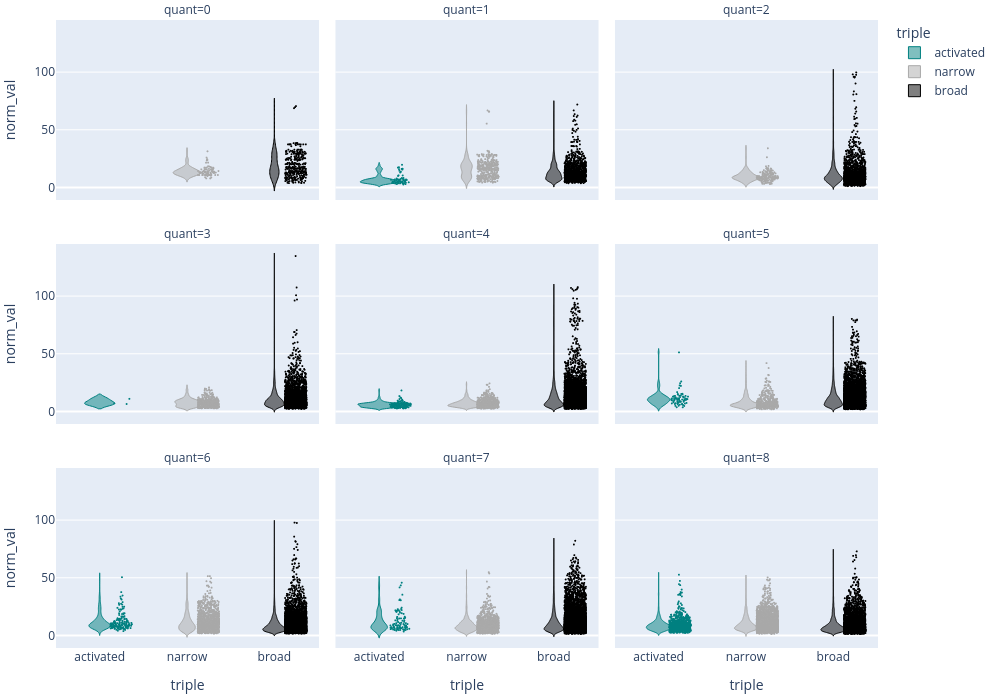

In [72]:
fig = px.violin(toplot, x='triple', y='norm_val', color='triple', facet_col='quant', facet_col_wrap=3,
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )
fig.update_traces(marker_size=2,
                  points='all',
                  pointpos=1,
                  jitter=0.5,
                  line_width=1,
                  scalemode='width')

fig.update_layout(margin=dict(t=20, b=10, l=10, r=10),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=700)
Image(img_bytes)

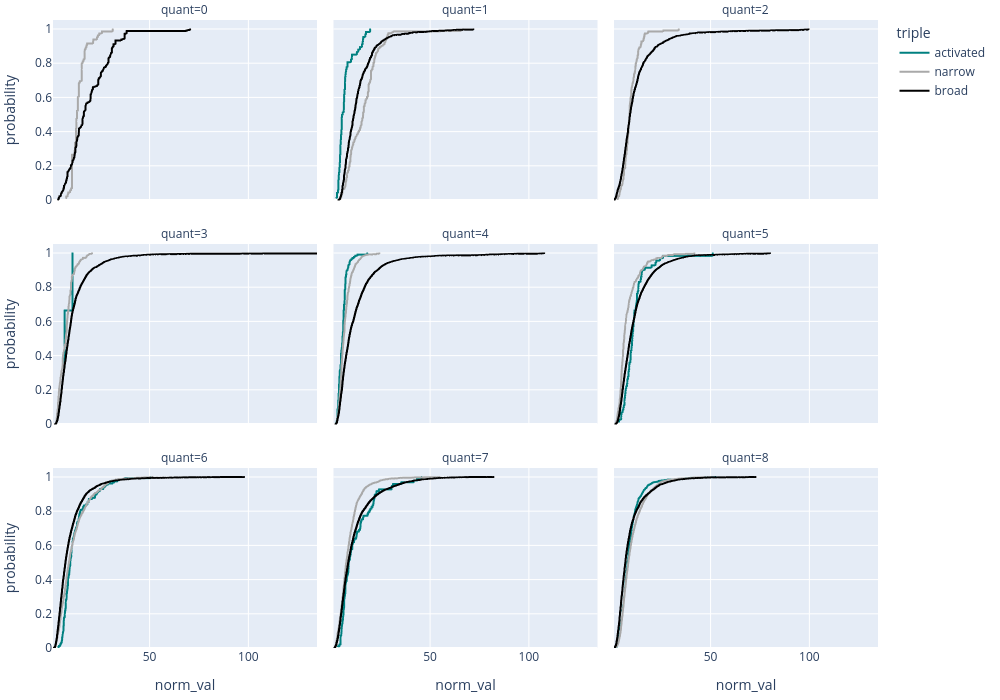

In [73]:
fig = px.ecdf(toplot, x='norm_val', color='triple', facet_col='quant', facet_col_wrap=3,
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )
fig.update_layout(margin=dict(t=20, b=10, l=10, r=10),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=700)
Image(img_bytes)

In [74]:
df = list()
for qq in toplot.quant.unique():
    mod = quantreg("norm_val ~ C(triple)", toplot.query(f"quant == {qq}"))
    res = mod.fit(q=0.75)

    # print(res.summary())
    ww = res.params
    ww.name = f'params'

    pp = res.pvalues
    pp.name = f'pvalues'

    out = pd.concat([ww, pp], axis=1)
    out.drop(index=['C(triple)[T.unclass]'], inplace=True)
    # out.rename(index={'Intercept':'activated','C(triple)[T.broad]': 'broad', 'C(triple)[T.narrow]':'narrow'},
    #            inplace=True)
    out['quant'] = qq
    df.append(out)
df = pd.concat(df)

df['significant'] = df['pvalues'] < (0.05 / df.shape[0])
df.reset_index(inplace=True)
df = df.sort_values(by=['quant', 'index'], ascending=[True, True], ignore_index=True)
df.set_index(['quant', 'index'], inplace=True)
print(df)

                              params        pvalues  significant
quant index                                                     
0     C(triple)[T.broad]   11.979324   1.234756e-54         True
      C(triple)[T.narrow]   1.842116   5.962858e-02        False
      Intercept            13.821440   7.185216e-90         True
1     C(triple)[T.broad]    9.192478   1.438205e-10         True
      C(triple)[T.narrow]  12.791078   7.032932e-17         True
      Intercept             7.331982   1.378911e-07         True
2     C(triple)[T.broad]    5.484997   1.659893e-51         True
      C(triple)[T.narrow]   3.110739   1.953809e-07         True
      Intercept             8.595735  5.938267e-141         True
3     C(triple)[T.broad]    2.123174   7.371438e-01        False
      C(triple)[T.narrow]  -1.318981   8.352272e-01        False
      Intercept            10.939832   8.367923e-02        False
4     C(triple)[T.broad]    8.187277   2.444959e-19         True
      C(triple)[T.narrow]

In [75]:
ww = res.params
ww.name = f'params'

pp = res.pvalues
pp.name = f'pvalues'

out = pd.concat([ww, pp], axis=1)
out.drop(index=['C(triple)[T.unclass]'], inplace=True)
out.rename(index={'Intercept':'activated','C(triple)[T.broad]': 'broad', 'C(triple)[T.narrow]':'narrow'},
           inplace=True)
out['quant'] = qq
out

,params,pvalues,quant
activated,14.094952,9.652960e-54,6
broad,-2.189528,1.714625e-02,6
narrow,0.189949,8.420640e-01,6


# list of CPN sites to phototag
nothing special, just to keep track of it

In [76]:
all_proc_sites = set(get_phototags().siteid)

all_opto_sites={'ARM004e', 'TNC006a', 'TNC008a', 'TNC009a', 'TNC010a', 'TNC011a',
       'TNC012a', 'TNC013a', 'TNC014a', 'TNC015a', 'TNC016a', 'TNC017a',
       'TNC018a', 'TNC019a', 'TNC020a', 'TNC021a', 'TNC022a', 'TNC023a',
       'TNC024a', 'TNC029a', 'TNC043a', 'TNC044a', 'TNC045a', 'TNC047a',
       'TNC048a', 'TNC049a', 'TNC050a', 'TNC051a', 'TNC062a', 'CLT027c',
       'CLT028c', 'CLT031c', 'CLT032c', 'CLT033c', 'CLT034c', 'CLT035c',
       'CLT036c', 'CLT037c', 'CLT038a', 'CLT039c', 'CLT040c', 'CLT041c',
       'CLT042a', 'CLT043b', 'CLT044d', 'CLT045d', 'CLT048c', 'CLT049c'}

all_ctx_sites= set(DF.site.unique())


all_unproc = set(all_opto_sites).difference(set(all_proc_sites))
ctx_unproc = all_unproc.intersection(set(all_ctx_sites))
ctx_unproc

set()